In [1]:
import wandb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import numpy as np
from collections import defaultdict
from cycler import cycler

In [2]:
api = wandb.Api()

# 1. Pull wandb runs from a specific organization and project
runs = api.runs('sita/llama')

# 2. Filter the runs
filtered_runs = [run for run in runs if run.config.get('num_epochs') == 30]

# 3. Group the runs by run.config.data_path
runs_by_path = defaultdict(list)
for run in filtered_runs:
    data_path = run.config.get('data_path')
    if data_path:
        runs_by_path[data_path].append(run)

print(f'Found {len(runs_by_path)} groups of runs:')
for data_path, runs in runs_by_path.items():
    print(f'{data_path}: {len(runs)} runs')

Found 4 groups of runs:
copypaste_mtag_n2id0_fracinc0.5_ug100_rg1000_gph1: 20 runs
copypaste_mtag_n2id0_fracinc0.25_ug100_rg1000_gph1: 20 runs
copypaste_mtag_n2id0_fracinc0.1_ug100_rg1000_gph1: 20 runs
copypaste_mtag_n2id0_ug100_rg1000_gph1: 20 runs


In [3]:
# Prepare color cycler
colors = plt.cm.cool(np.linspace(0,1,6))[::-1]  # Generate 6 colors from cool colormap in reversed order
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

In [4]:
# 4. Make data for the plot
plot_data = []
for data_path, runs in runs_by_path.items():
    # Extract FRACTION_INCORRECT
    match = re.search(r'fracinc([0-9\.]+)', data_path)
    if match:
        fraction_incorrect = float(match.group(1))
    else:
        fraction_incorrect = 0.0  # Default value if not found

    # Prepare for plotting
    reliability = int((1 - fraction_incorrect) * 100)
    label = f"{reliability}% reliable"

    # Collect epoch and accuracy data across runs for the same data path
    accuracies_by_epoch = defaultdict(list)
    for run in runs:
        history = run.scan_history(keys=['train/epoch', 'eval/accuracy'])
        for row in history:
            accuracies_by_epoch[row['train/epoch']].append(row['eval/accuracy'])

    # Convert to numpy arrays for easier manipulation
    epochs = np.array(list(accuracies_by_epoch.keys()))
    accuracies = np.array(list(accuracies_by_epoch.values()))

    # Calculate mean and standard deviation
    mean_accuracy = np.mean(accuracies, axis=1)
    std_accuracy = np.std(accuracies, axis=1)

    # Plot mean accuracy and standard deviation
    plot_data.append((epochs, mean_accuracy, std_accuracy, label))

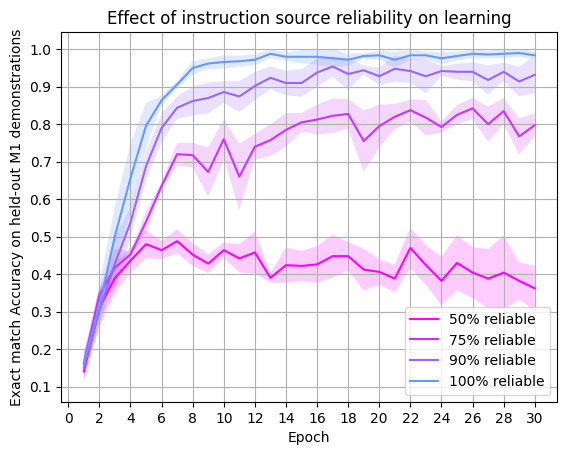

In [5]:
for group in plot_data:
    epochs, mean_accuracy, std_accuracy, label = group
    plt.plot(epochs, mean_accuracy, label=label)
    plt.fill_between(epochs, mean_accuracy-std_accuracy, mean_accuracy+std_accuracy, alpha=0.2)


# Show the plot
plt.grid(True)


ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15+1))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10+1))


plt.title('Effect of instruction source reliability on learning')
plt.xlabel('Epoch')
plt.ylabel('Exact match Accuracy on held-out M1 demonstrations')
plt.legend(loc='lower right')
plt.savefig('reliability.png', dpi=300)
plt.savefig('reliability.pdf', dpi=300)

In [8]:
import pandas as pd

# Initialize a DataFrame to store the final results
results_df = pd.DataFrame(columns=['Group', 'Accuracy (max of avg over 5 runs)', 'Standard Deviation'])


for group in plot_data:
    epochs, mean_accuracy, std_accuracy, label = group
    max_mean_accuracy = max(mean_accuracy)
    std_dev = std_accuracy[-1]

    results_df = results_df.append({
        'Group': label,
        'Accuracy (max of avg over 5 runs)': max_mean_accuracy,
        # limit std to 3 decimal places
        'Standard Deviation': f'{std_dev:.3f}',
    }, ignore_index=True)

# Display the DataFrame
results_df


/tmp/ipykernel_31067/2626466098.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_31067/2626466098.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_31067/2626466098.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_31067/2626466098.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


,Group,Accuracy (max of avg over 5 runs),Standard Deviation
0,50% reliable,0.4880,0.060
1,75% reliable,0.8425,0.031
2,90% reliable,0.9540,0.050
3,100% reliable,0.9900,0.010


In [51]:
# Convert the DataFrame to markdown
markdown_df = results_df.copy()
markdown_df['Accuracy (avg over 5 runs)'] = markdown_df.apply(lambda row: f"{row['Accuracy (avg over 5 runs)']} (STD: {row['Standard Deviation']})", axis=1)
markdown_df = markdown_df.drop(columns='Standard Deviation')

# Print the DataFrame in markdown format
print(markdown_df.to_markdown(index=False))
print(markdown_df.to_latex(index=False))



| Group                    | Accuracy (avg over 5 runs)      |
|:-------------------------|:--------------------------------|
| 50% reliable [LLaMA-7B]  | 0.4880000000000001 (STD: 0.039) |
| 75% reliable [LLaMA-7B]  | 0.778 (STD: 0.019)              |
| 90% reliable [LLaMA-7B]  | 0.9199999999999999 (STD: 0.030) |
| 100% reliable [LLaMA-7B] | 0.984 (STD: 0.014)              |
\begin{tabular}{ll}
\toprule
                   Group &      Accuracy (avg over 5 runs) \\
\midrule
 50\% reliable [LLaMA-7B] & 0.4880000000000001 (STD: 0.039) \\
 75\% reliable [LLaMA-7B] &              0.778 (STD: 0.019) \\
 90\% reliable [LLaMA-7B] & 0.9199999999999999 (STD: 0.030) \\
100\% reliable [LLaMA-7B] &              0.984 (STD: 0.014) \\
\bottomrule
\end{tabular}



/var/folders/fp/2b103mk15m173df0t9_rd58c0000gn/T/ipykernel_65399/948920517.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(markdown_df.to_latex(index=False))


| Group                    | Final Accuracy (avg over 5 runs)      |
|:-------------------------|:--------------------------------|
| 50% reliable  | 0.488 (STD: 0.039) |
| 75% reliable  | 0.778 (STD: 0.019)              |
| 90% reliable  | 0.919 (STD: 0.030) |
| 100% reliable | 0.984 (STD: 0.014)              |